In [8]:
import re
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix


# Exercise 3: Sparse Matrices, Static and Transient Problem of Governor

a) The mass and stiffness matrices were exported from Ansys in the Harwell-Boeing format for sparse matrices. Write a function to import the matrices located in the files M_L.txt and K_L.txt.

In [9]:
def conv(value):
    try:
        return float(value)
    except ValueError:
        return float(re.sub(r"D", 'E', str(value, 'utf-8')))

def read_hb(file_path):
    with open(file_path) as file:
        # First line
        line = file.readline().strip("\n")
        if not len(line) > 72:
            raise ValueError("Expected at least 72 characters for first line, "
                             "got: \n%s" % line)
        title = line[:72]
        key = line[72:]

        # Second line
        line = file.readline().strip("\n")
        if not len(line.rstrip()) >= 56:
            raise ValueError("Expected at least 56 characters for second line, "
                         "got: \n%s" % line)
        total_nlines = int(line[:14])
        pointer_nlines = int(line[14:28])
        indices_nlines = int(line[28:42])
        values_nlines = int(line[42:56])

        data = np.loadtxt(file_path, skiprows=5, converters={0: conv})

        indptr = data[:pointer_nlines].astype(int) - 1
        indices = data[pointer_nlines:pointer_nlines + indices_nlines].astype(int) - 1
        values = data[pointer_nlines + indices_nlines:pointer_nlines + indices_nlines + values_nlines]

        sparse_matrix = csc_matrix((values, indices, indptr))

        # Symmetrization of scipy sparse matrices
        rows, cols = sparse_matrix.nonzero()
        sparse_matrix[cols, rows] = sparse_matrix[rows, cols]

    return sparse_matrix

Execute function ```read_hb```.

In [10]:
resources_path = os.path.join('resources')
K_L_path = os.path.join(resources_path, 'K_L.txt')
M_L_path = os.path.join(resources_path, 'M_L.txt')

K_txt = read_hb(K_L_path)
M_txt = read_hb(M_L_path)

/usr/local/anaconda3/envs/MRoMS/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Compare the results with the already imported matrices

In [11]:
from pymatreader import read_mat

def read_hb_from_mat(file_path, name):
    mat_dic = read_mat(file_path)[name]
    indptr = mat_dic['jc']
    indices = mat_dic['ir']
    values = mat_dic['data']
    return csc_matrix((values, indices, indptr))

def is_equal(sparse_A, sparse_B):
    return np.allclose(sparse_A.A, sparse_B.A)

In [12]:
K_mat_path = os.path.join(resources_path, 'K.mat')
M_mat_path = os.path.join(resources_path, 'M.mat')

K_mat = read_hb_from_mat(K_mat_path, 'K')
M_mat = read_hb_from_mat(M_mat_path, 'M')

# Equality check
print(f'The equality check of K_txt and K_mat results in {is_equal(K_txt, K_mat)}')
print(f'The equality check of M_txt and M_mat results in {is_equal(M_txt, M_mat)}')

The equality check of K_txt and K_mat results in True
The equality check of M_txt and M_mat results in True


Alternative use already implemented functions
```
scipy.io.hb_read
scipy.io.hb_write
```

In [13]:
from scipy.io.harwell_boeing import hb_read, hb_write
K_hb_path = os.path.join(resources_path, 'K.hb')
M_hb_path = os.path.join(resources_path, 'M.hb')
hb_write(M_hb_path, M_mat)
hb_write(K_hb_path, K_mat)

M_hb = hb_read(M_hb_path)
K_hb = hb_read(K_hb_path)

(b) Plot the sparsity pattern of the matrices with the Matlab function spy.
Using ```matplotlib.pylab.spy```.

Text(0.5, 1.0, 'Sparsity of the Stiffness Matrix')

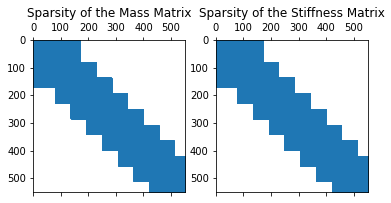

In [14]:
M = M_txt
K = K_txt

fig, axes = plt.subplots(1,2)
ax = axes.ravel()
ax[0].spy(M)
ax[0].set_title("Sparsity of the Mass Matrix")
ax[1].spy(K)
ax[1].set_title("Sparsity of the Stiffness Matrix")